In [60]:
import time, joblib, os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from utils.dataset import load_dataset
import scipy.stats as st

In [3]:
data_root_path = 'data'+os.sep
data_paths = os.listdir('data')
start_time = time.strftime('%Y%m%d-%H%M%S', time.localtime(time.time()))

In [4]:
train_dataset_indices = [12, 16, 13, 15, 14, 10, 9, 11, 4, 3, 1, 5, 7, 6, 2, 8, 17, 21, 18, 24, 23, 19, 20, 22]
val_dataset_indices = [31, 30, 26, 28, 29, 27, 25, 32]

In [5]:
train_dataset = load_dataset(train_dataset_indices)
val_dataset = load_dataset(val_dataset_indices)

loading dataset...:   0%|          | 0/24 [00:00<?, ?it/s]

loading dataset...:   0%|          | 0/8 [00:00<?, ?it/s]

In [63]:
state = []

for speed, outlet_flow in zip(train_dataset['motor_speed(rpm)'], train_dataset['venturi_pump_outlet_F(LPM)']):
    if speed == 750:
        if outlet_flow <= 850:
            state.append(1)
        else:
            state.append(0)
            
    if speed == 900:
        if outlet_flow <= 1100:
            state.append(1)
        else:
            state.append(0)

train_dataset['transient_state'] = state

In [64]:
train_dataset

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0         0.000                  -0.023                   -0.127   
1         0.018                  -0.028                   -0.127   
2         0.064                   0.003                   -0.127   
3         0.115                   0.024                   -0.127   
4         0.164                   0.006                   -0.127   
...         ...                     ...                      ...   
2060    102.967                  -0.014                   -0.124   
2061    103.017                  -0.054                   -0.123   
2062    103.067                  -0.054                   -0.124   
2063    103.117                  -0.093                   -0.124   
2064    103.167                  -0.058                   -0.123   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                        -0.076                   -3.036   
1                        -0.076                   -3.030   
2                        -0.079                   -2.801   
3                        -0.077                   -4.118   
4                        -0.078                   -3.055   
...                         ...                      ...   
2060                     -0.112                   -4.319   
2061                     -0.109                   -3.017   
2062                     -0.113                   -4.061   
2063                     -0.112                   -3.101   
2064                     -0.111                   -3.390   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         -4.319               900              45   
1                         -3.790               900              45   
2                         -3.320               900              45   
3                         -3.212               900              45   
4                         -4.427               900              45   
...                          ...               ...             ...   
2060                      26.642               900              30   
2061                      26.486               900              30   
2062                      25.685               900              30   
2063                      26.091               900              30   
2064                      26.820               900              30   

      suction_height_of_venturi(m)  run_name      state  transient_state  
0                            -0.65        12  transient                1  
1                            -0.65        12  transient                1  
2                            -0.65        12  transient                1  
3                            -0.65        12  transient                1  
4                            -0.65        12  transient                1  
...                            ...       ...        ...              ...  
2060                         -0.45        22  transient                1  
2061                         -0.45        22  transient                1  
2062                         -0.45        22  transient                1  
2063                         -0.45        22  transient                1  
2064                         -0.45        22  transient                1  

[51493 rows x 12 columns]

In [65]:
train_feature = train_dataset[['main_pump_inlet_P(bar)', 'main_pump_outlet_F(LPM)', 'venturi_pump_inlet_P(bar)']]
train_feature

main_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                     -0.023                   -3.036   
1                     -0.028                   -3.030   
2                      0.003                   -2.801   
3                      0.024                   -4.118   
4                      0.006                   -3.055   
...                      ...                      ...   
2060                  -0.014                   -4.319   
2061                  -0.054                   -3.017   
2062                  -0.054                   -4.061   
2063                  -0.093                   -3.101   
2064                  -0.058                   -3.390   

      venturi_pump_inlet_P(bar)  
0                        -0.076  
1                        -0.076  
2                        -0.079  
3                        -0.077  
4                        -0.078  
...                         ...  
2060                     -0.112  
2061                     -0.109  
2062                     -0.113  
2063                     -0.112  
2064                     -0.111  

[51493 rows x 3 columns]

In [66]:
train_target = train_dataset['transient_state']
train_target

0       1
1       1
2       1
3       1
4       1
       ..
2060    1
2061    1
2062    1
2063    1
2064    1
Name: transient_state, Length: 51493, dtype: int64

In [67]:
state = []

for speed, outlet_flow in zip(val_dataset['motor_speed(rpm)'], val_dataset['venturi_pump_outlet_F(LPM)']):
    if speed == 750:
        if outlet_flow <= 850:
            state.append(1)
        else:
            state.append(0)
            
    if speed == 900:
        if outlet_flow <= 1100:
            state.append(1)
        else:
            state.append(0)

val_dataset['transient_state'] = state

In [68]:
val_feature = val_dataset[['main_pump_inlet_P(bar)', 'main_pump_outlet_P(bar)', 'venturi_pump_inlet_P(bar)']]
val_feature

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0                     -0.054                   -0.126   
1                      0.003                   -0.126   
2                     -0.002                   -0.126   
3                     -0.015                   -0.126   
4                      0.021                   -0.126   
...                      ...                      ...   
2019                  -0.056                   -0.126   
2020                  -0.071                   -0.126   
2021                  -0.063                   -0.126   
2022                   0.006                   -0.126   
2023                  -0.085                   -0.127   

      venturi_pump_inlet_P(bar)  
0                        -0.100  
1                        -0.100  
2                        -0.099  
3                        -0.097  
4                        -0.092  
...                         ...  
2019                     -0.101  
2020                     -0.097  
2021                     -0.097  
2022                     -0.088  
2023                     -0.095  

[16607 rows x 3 columns]

In [69]:
val_target = val_dataset['transient_state'].to_numpy()
val_target

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [70]:
transient_model = LGBMClassifier()
transient_model.fit(train_feature, train_target)

[LightGBM] [Info] Number of positive: 42617, number of negative: 8876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 51493, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.827627 -> initscore=1.568902
[LightGBM] [Info] Start training from score 1.568902


LGBMClassifier()

In [71]:
pred = transient_model.predict(val_feature)

In [72]:
accuracy_score(val_target, pred)

0.7623291383151684

In [73]:
precision_score(val_target, pred)

0.7623291383151684

In [74]:
recall_score(val_target, pred)

1.0

In [75]:
f1_score(val_target, pred)

0.8651382102709536

In [76]:
val_dataset['pred_transient_state'] = pred

In [77]:
val_dataset

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0         0.000                  -0.054                   -0.126   
1         0.046                   0.003                   -0.126   
2         0.096                  -0.002                   -0.126   
3         0.147                  -0.015                   -0.126   
4         0.196                   0.021                   -0.126   
...         ...                     ...                      ...   
2019    100.941                  -0.056                   -0.126   
2020    100.990                  -0.071                   -0.126   
2021    101.040                  -0.063                   -0.126   
2022    101.090                   0.006                   -0.126   
2023    101.140                  -0.085                   -0.127   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                        -0.100                   -4.311   
1                        -0.100                   -4.307   
2                        -0.099                   -3.207   
3                        -0.097                   -4.004   
4                        -0.092                   -3.979   
...                         ...                      ...   
2019                     -0.101                   -3.402   
2020                     -0.097                   -2.990   
2021                     -0.097                   -3.969   
2022                     -0.088                   -3.603   
2023                     -0.095                   -3.344   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         31.191               750              45   
1                         32.456               750              45   
2                         32.615               750              45   
3                         32.398               750              45   
4                         31.297               750              45   
...                          ...               ...             ...   
2019                      39.868               900              45   
2020                      39.296               900              45   
2021                      40.094               900              45   
2022                      40.273               900              45   
2023                      40.266               900              45   

      suction_height_of_venturi(m)  run_name      state  transient_state  \
0                            -0.45        31  transient                1   
1                            -0.45        31  transient                1   
2                            -0.45        31  transient                1   
3                            -0.45        31  transient                1   
4                            -0.45        31  transient                1   
...                            ...       ...        ...              ...   
2019                         -0.45        32  transient                1   
2020                         -0.45        32  transient                1   
2021                         -0.45        32  transient                1   
2022                         -0.45        32  transient                1   
2023                         -0.45        32  transient                1   

      pred_transient_state  
0                        1  
1                        1  
2                        1  
3                        1  
4                        1  
...                    ...  
2019                     1  
2020                     1  
2021                     1  
2022                     1  
2023                     1  

[16607 rows x 13 columns]

In [18]:
dataset = pd.concat([train_dataset, val_dataset], axis=0)
dataset

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0         0.000                  -0.023                   -0.127   
1         0.018                  -0.028                   -0.127   
2         0.064                   0.003                   -0.127   
3         0.115                   0.024                   -0.127   
4         0.164                   0.006                   -0.127   
...         ...                     ...                      ...   
2019    100.941                  -0.056                   -0.126   
2020    100.990                  -0.071                   -0.126   
2021    101.040                  -0.063                   -0.126   
2022    101.090                   0.006                   -0.126   
2023    101.140                  -0.085                   -0.127   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                        -0.076                   -3.036   
1                        -0.076                   -3.030   
2                        -0.079                   -2.801   
3                        -0.077                   -4.118   
4                        -0.078                   -3.055   
...                         ...                      ...   
2019                     -0.101                   -3.402   
2020                     -0.097                   -2.990   
2021                     -0.097                   -3.969   
2022                     -0.088                   -3.603   
2023                     -0.095                   -3.344   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         -4.319               900              45   
1                         -3.790               900              45   
2                         -3.320               900              45   
3                         -3.212               900              45   
4                         -4.427               900              45   
...                          ...               ...             ...   
2019                      39.868               900              45   
2020                      39.296               900              45   
2021                      40.094               900              45   
2022                      40.273               900              45   
2023                      40.266               900              45   

      suction_height_of_venturi(m)  run_name  
0                            -0.65        12  
1                            -0.65        12  
2                            -0.65        12  
3                            -0.65        12  
4                            -0.65        12  
...                            ...       ...  
2019                         -0.45        32  
2020                         -0.45        32  
2021                         -0.45        32  
2022                         -0.45        32  
2023                         -0.45        32  

[68100 rows x 10 columns]

In [13]:
venturi_outlet_f_outlier = named_raw_dataset['venturi_pump_outlet_F(LPM)']<0
sum(venturi_outlet_f_outlier)/len(venturi_outlet_f_outlier)

0.06462555066079295

In [16]:
named_val_dataset = named_val_dataset[named_val_dataset['main_pump_inlet_P(bar)']<1]
named_val_dataset = named_val_dataset[named_val_dataset['main_pump_outlet_P(bar)']>0]
named_val_dataset = named_val_dataset[named_val_dataset['venturi_pump_inlet_P(bar)']>0]
named_val_dataset = named_val_dataset[named_val_dataset['venturi_pump_outlet_F(LPM)']>0]
named_val_dataset.reset_index(drop=True, inplace=True)

In [19]:
val_feature = named_val_dataset['main_pump_inlet_P(bar)']
val_feature = pd.concat([val_feature, named_val_dataset['main_pump_outlet_P(bar)']], axis=1)
val_feature = pd.concat([val_feature, named_val_dataset['venturi_pump_inlet_P(bar)']], axis=1)

val_target = named_val_dataset['venturi_pump_outlet_F(LPM)']

In [20]:
raw_dataset = named_raw_dataset.drop(columns=['time(sec)', 'venturi_pump_outlet_F(LPM)', 'motor_speed(rpm)', 'hose_length(m)', 'suction_height_of_venturi(m)', 'run_name'])

In [21]:
raw_dataset.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count            35934.000000             35934.000000   
mean                -1.867752                 0.271844   
std                  0.096569                 0.095770   
min                 -2.226000                 0.001000   
25%                 -1.934000                 0.226000   
50%                 -1.869000                 0.243000   
75%                 -1.802000                 0.368000   
max                 -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  
count               35934.000000             35934.000000  
mean                    1.554708               146.956906  
std                     0.441771                79.288370  
min                     0.001000                -4.797000  
25%                     1.357000                82.974750  
50%                     1.381000               147.527000  
75%                     2.015000               234.412250  
max                     2.075000               248.715000

In [26]:
named_raw_dataset[named_raw_dataset['hose_length(m)']==30].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  18352.000000            18352.000000             18352.000000   
mean      44.012484               -1.862385                 0.266179   
std       17.418507                0.096850                 0.094438   
min       11.767000               -2.224000                 0.001000   
25%       29.239500               -1.930000                 0.222000   
50%       43.677500               -1.864000                 0.238000   
75%       58.294250               -1.796000                 0.365000   
max       89.548000               -1.476000                 0.388000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               18352.000000             18352.000000   
mean                    1.554915               148.540041   
std                     0.443660                77.724358   
min                     0.003000                -4.706000   
25%                     1.360000                85.060750   
50%                     1.382000               146.939500   
75%                     2.019000               234.422000   
max                     2.075000               248.715000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                18352.000000      18352.000000         18352.0   
mean                   802.174234        826.283239            30.0   
std                    326.149898         74.991064             0.0   
min                      1.447000        750.000000            30.0   
25%                    754.685500        750.000000            30.0   
50%                    904.196500        900.000000            30.0   
75%                   1039.983000        900.000000            30.0   
max                   1166.268000        900.000000            30.0   

       suction_height_of_venturi(m)      run_name  
count                  18352.000000  18352.000000  
mean                      -0.553237     15.251144  
std                        0.099950      9.278557  
min                       -0.650000      1.000000  
25%                       -0.650000      6.000000  
50%                       -0.650000     14.000000  
75%                       -0.450000     22.000000  
max                       -0.450000     30.000000

In [27]:
named_raw_dataset[named_raw_dataset['hose_length(m)']==45].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  17582.000000            17582.000000             17582.000000   
mean      43.761028               -1.873355                 0.277756   
std       16.924082                0.095957                 0.096789   
min       11.818000               -2.226000                 0.001000   
25%       29.440500               -1.939000                 0.229000   
50%       43.497000               -1.874000                 0.250000   
75%       57.754750               -1.809000                 0.372000   
max       81.598000               -1.514000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               17582.000000             17582.000000   
mean                    1.554492               145.304439   
std                     0.439802                80.857785   
min                     0.001000                -4.797000   
25%                     1.355000                76.023000   
50%                     1.380000               147.707500   
75%                     2.010000               234.409000   
max                     2.063000               247.988000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                17582.000000      17582.000000         17582.0   
mean                   789.424086        826.219998            45.0   
std                    334.301829         74.992209             0.0   
min                      0.355000        750.000000            45.0   
25%                    725.150500        750.000000            45.0   
50%                    894.627000        900.000000            45.0   
75%                   1047.137500        900.000000            45.0   
max                   1186.057000        900.000000            45.0   

       suction_height_of_venturi(m)     run_name  
count                  17582.000000  17582.00000  
mean                      -0.550353     18.10943  
std                        0.100002      9.09238  
min                       -0.650000      3.00000  
25%                       -0.650000     11.00000  
50%                       -0.650000     19.00000  
75%                       -0.450000     27.00000  
max                       -0.450000     32.00000

In [29]:
named_raw_dataset[named_raw_dataset['suction_height_of_venturi(m)']==-0.65].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  18295.000000            18295.000000             18295.000000   
mean      45.003350               -1.870027                 0.272798   
std       17.657312                0.096415                 0.095299   
min       11.818000               -2.226000                 0.001000   
25%       30.051500               -1.936000                 0.225000   
50%       44.616000               -1.873000                 0.242000   
75%       59.438500               -1.805000                 0.366000   
max       89.548000               -1.514000                 0.404000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               18295.000000              18295.00000   
mean                    1.579188                151.08201   
std                     0.433569                 78.67529   
min                     0.003000                 -4.79700   
25%                     1.365000                 99.92650   
50%                     1.388000                158.41300   
75%                     2.018000                235.35450   
max                     2.075000                248.71500   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                18295.000000      18295.000000    18295.000000   
mean                   809.478451        828.045914       37.233124   
std                    333.686895         74.940172        7.495455   
min                      0.930000        750.000000       30.000000   
25%                    763.092000        750.000000       30.000000   
50%                    904.757000        900.000000       30.000000   
75%                   1070.536500        900.000000       45.000000   
max                   1186.057000        900.000000       45.000000   

       suction_height_of_venturi(m)      run_name  
count                  1.829500e+04  18295.000000  
mean                  -6.500000e-01     14.659415  
std                    1.110253e-16      9.113957  
min                   -6.500000e-01      1.000000  
25%                   -6.500000e-01      9.000000  
50%                   -6.500000e-01     17.000000  
75%                   -6.500000e-01     25.000000  
max                   -6.500000e-01     28.000000

In [30]:
named_raw_dataset[named_raw_dataset['suction_height_of_venturi(m)']==-0.45].describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  17639.000000            17639.000000             17639.000000   
mean      42.734124               -1.865393                 0.270854   
std       16.589212                0.096675                 0.096248   
min       11.767000               -2.218000                 0.001000   
25%       28.613000               -1.932000                 0.228000   
50%       42.556000               -1.865000                 0.243000   
75%       56.694500               -1.799000                 0.370000   
max       81.598000               -1.476000                 0.398000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count               17639.000000             17639.000000   
mean                    1.529318               142.678389   
std                     0.448723                79.696243   
min                     0.001000                -4.790000   
25%                     1.353000                72.576000   
50%                     1.371000               127.564000   
75%                     2.013000               233.670500   
max                     2.061000               247.101000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                17639.000000      17639.000000    17639.000000   
mean                   781.889424        824.391972       37.449402   
std                    326.002109         74.999661        7.500042   
min                      0.355000        750.000000       30.000000   
25%                    722.041000        750.000000       30.000000   
50%                    882.323000        750.000000       30.000000   
75%                   1023.161500        900.000000       45.000000   
max                   1138.280000        900.000000       45.000000   

       suction_height_of_venturi(m)      run_name  
count                  1.763900e+04  17639.000000  
mean                  -4.500000e-01     18.713929  
std                    1.110254e-16      9.033911  
min                   -4.500000e-01      5.000000  
25%                   -4.500000e-01     13.000000  
50%                   -4.500000e-01     21.000000  
75%                   -4.500000e-01     29.000000  
max                   -4.500000e-01     32.000000

In [33]:
train_feature.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count            26629.000000             26629.000000   
mean                -1.873599                 0.272163   
std                  0.096012                 0.095743   
min                 -2.226000                 0.001000   
25%                 -1.939000                 0.224000   
50%                 -1.875000                 0.245000   
75%                 -1.808000                 0.368000   
max                 -1.476000                 0.404000   

       venturi_pump_inlet_P(bar)  
count               26629.000000  
mean                    1.558028  
std                     0.445622  
min                     0.001000  
25%                     1.357000  
50%                     1.382000  
75%                     2.016000  
max                     2.075000

In [34]:
train_target.describe()

count    26629.000000
mean       792.531409
std        329.589597
min          0.355000
25%        733.149000
50%        892.876000
75%       1039.717000
max       1186.057000
Name: venturi_pump_outlet_F(LPM), dtype: float64

In [35]:
val_feature.describe()

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count             9305.000000              9305.000000   
mean                -1.851021                 0.270931   
std                  0.096207                 0.095845   
min                 -2.195000                 0.001000   
25%                 -1.919000                 0.230000   
50%                 -1.852000                 0.240000   
75%                 -1.785000                 0.370000   
max                 -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  
count                9305.000000  
mean                    1.545206  
std                     0.430442  
min                     0.011000  
25%                     1.358000  
50%                     1.378000  
75%                     2.013000  
max                     2.052000

In [36]:
val_target.describe()

count    9305.000000
mean      805.678338
std       331.844553
min         1.748000
25%       772.010000
50%       911.693000
75%      1062.772000
max      1131.759000
Name: venturi_pump_outlet_F(LPM), dtype: float64

<Axes: >

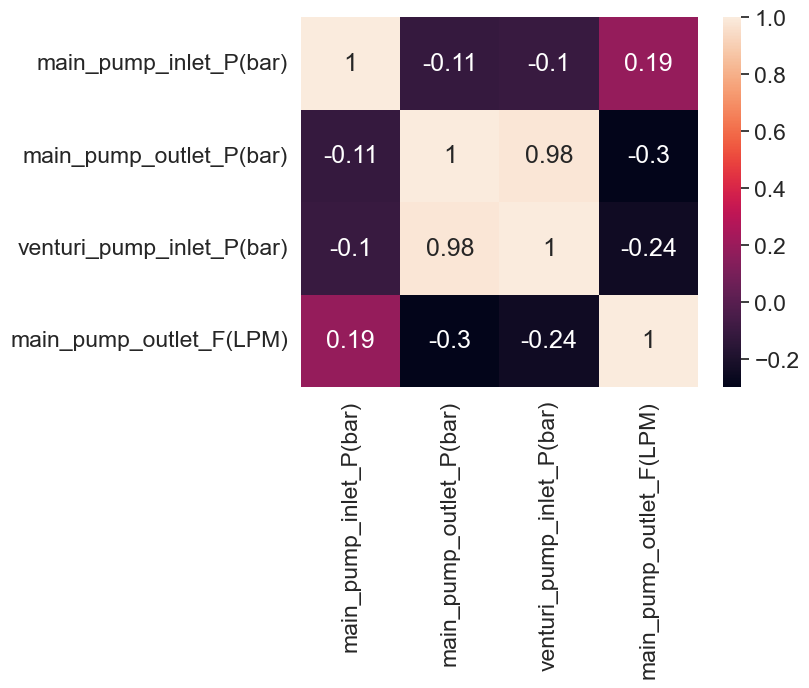

In [39]:
sns.set(font_scale=1.5)
sns.heatmap(raw_dataset.corr(), annot=True)

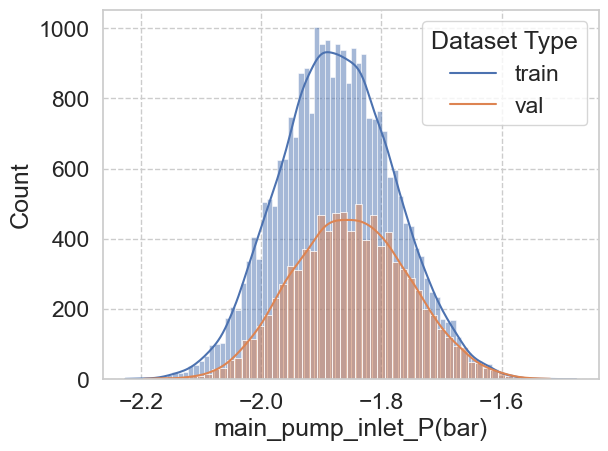

In [40]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_feature['main_pump_inlet_P(bar)'], kde='True')
sns.histplot(val_feature['main_pump_inlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])
#prob = np.histogram(refined_dataset['main_pump_inlet_P(bar)'], bins=np.linspace(-3, -1, 31))
#entropy(pk=prob[0]/len(refined_dataset['main_pump_inlet_P(bar)']), base=2)

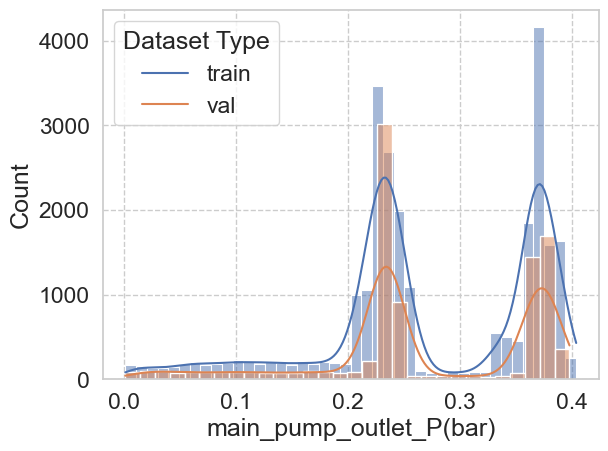

In [41]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_feature['main_pump_outlet_P(bar)'], kde='True')
sns.histplot(val_feature['main_pump_outlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

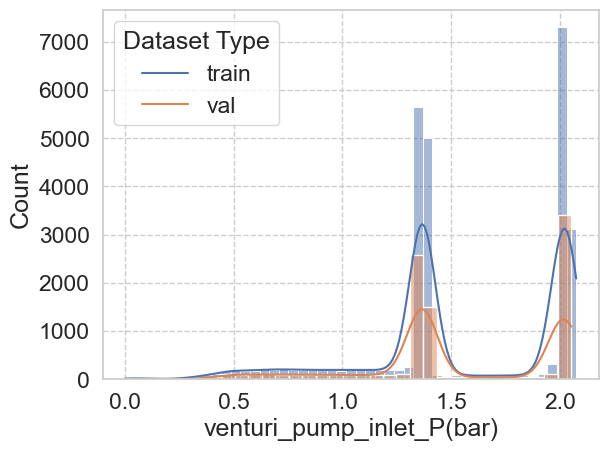

In [42]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_feature['venturi_pump_inlet_P(bar)'], kde='True')
sns.histplot(val_feature['venturi_pump_inlet_P(bar)'], kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

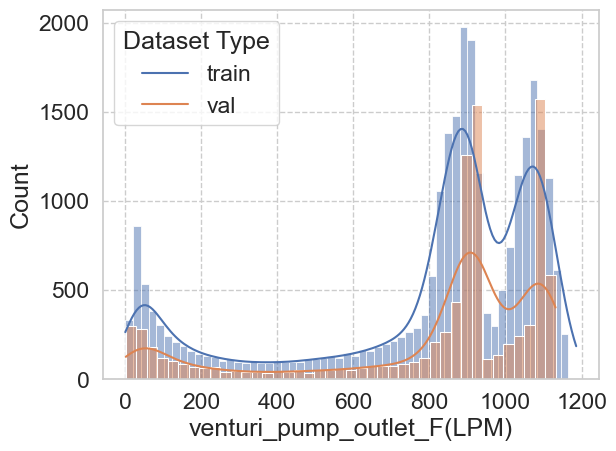

In [43]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(train_target, kde='True')
sns.histplot(val_target, kde='True')
plt.legend(title='Dataset Type', labels=['train', 'val'])

(0.0, 1200.0)

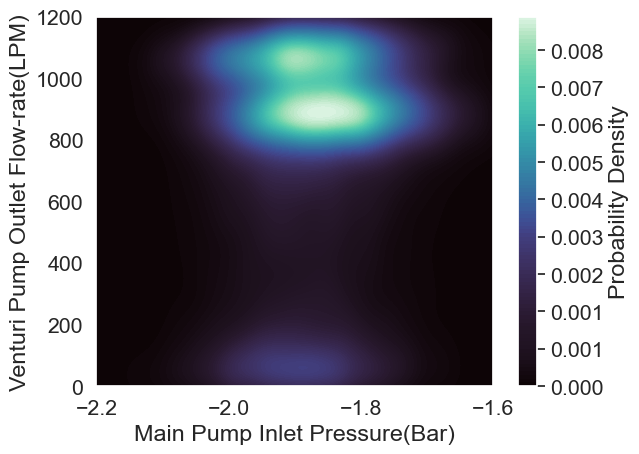

In [45]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=train_feature['main_pump_inlet_P(bar)'], y=train_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(-2.2, -1.6)
plt.ylim(0, 1200)

(0.0, 1200.0)

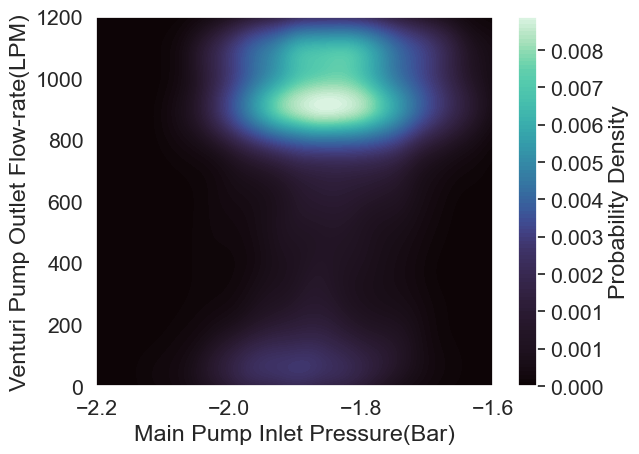

In [46]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=val_feature['main_pump_inlet_P(bar)'], y=val_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(-2.2, -1.6)
plt.ylim(0, 1200)

(0.0, 1200.0)

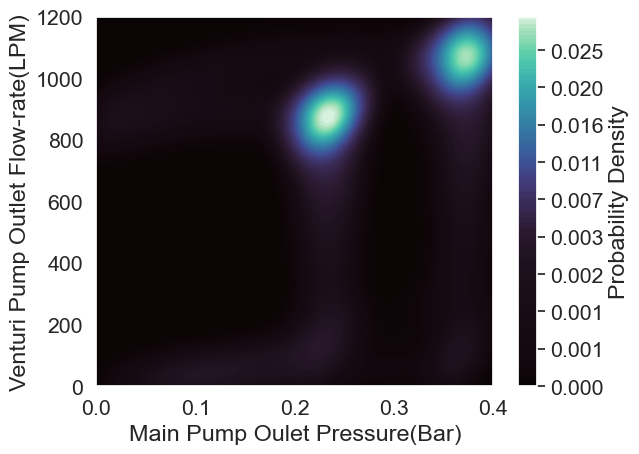

In [48]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=train_feature['main_pump_outlet_P(bar)'], y=train_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Oulet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(0, 0.4)
plt.ylim(0, 1200)

(0.0, 1200.0)

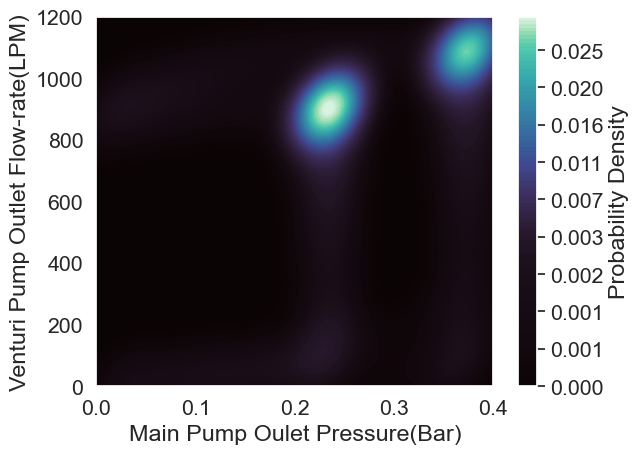

In [49]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=val_feature['main_pump_outlet_P(bar)'], y=val_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Main Pump Oulet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(0, 0.4)
plt.ylim(0, 1200)

In [51]:
x_axis = list(range(0, 24, 2))

for i, v in enumerate(x_axis):
    x_axis[i] = v/10
    
x_axis

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]

(0.0, 1200.0)

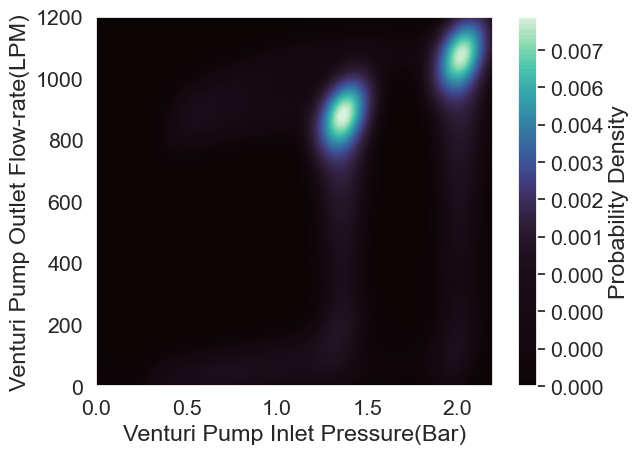

In [52]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=train_feature['venturi_pump_inlet_P(bar)'], y=train_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Venturi Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(0, 2.2)
plt.ylim(0, 1200)

(0.0, 1200.0)

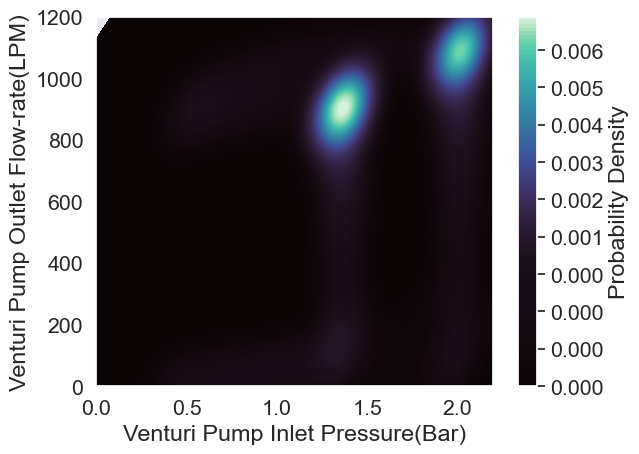

In [53]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_theme(style='dark')
sns.set(font_scale=1.4)
sns.kdeplot(x=val_feature['venturi_pump_inlet_P(bar)'], y=val_target, thresh=0, levels=100, fill=True, cmap='mako', cbar=True, cbar_kws={'label': 'Probability Density', 'format': '%.3f'})
plt.xlabel('Venturi Pump Inlet Pressure(Bar)')
plt.ylabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.xlim(0, 2.2)
plt.ylim(0, 1200)

In [54]:
train_feature

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0                      -1.865                    0.102   
1                      -1.860                    0.102   
2                      -1.840                    0.106   
3                      -1.822                    0.107   
4                      -1.866                    0.115   
...                       ...                      ...   
26624                  -1.843                    0.006   
26625                  -1.999                    0.004   
26626                  -1.955                    0.004   
26627                  -1.959                    0.001   
26628                  -1.798                    0.002   

       venturi_pump_inlet_P(bar)  
0                          0.767  
1                          0.753  
2                          0.757  
3                          0.783  
4                          0.782  
...                          ...  
26624                      0.411  
26625                      0.430  
26626                      0.402  
26627                      0.396  
26628                      0.374  

[26629 rows x 3 columns]

In [55]:
val_feature

main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0                     -1.730                    0.037   
1                     -2.013                    0.037   
2                     -1.887                    0.038   
3                     -1.787                    0.038   
4                     -1.921                    0.036   
...                      ...                      ...   
9300                  -1.829                    0.012   
9301                  -1.893                    0.010   
9302                  -1.728                    0.005   
9303                  -2.049                    0.005   
9304                  -1.629                    0.001   

      venturi_pump_inlet_P(bar)  
0                         0.026  
1                         0.099  
2                         0.181  
3                         0.320  
4                         0.326  
...                         ...  
9300                      0.470  
9301                      0.467  
9302                      0.449  
9303                      0.443  
9304                      0.450  

[9305 rows x 3 columns]

In [56]:
# create linear regression model
linear_model = LinearRegression()
linear_model.fit(train_feature, train_target)
print(linear_model.coef_)
print(linear_model.intercept_)

[  386.81131646 -4211.68607923  1217.0623079 ]
767.3066310030625


In [57]:
pred_output = linear_model.predict(val_feature)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

linear_result = pd.DataFrame(['linear']*len(pred_output), columns=['model_type'])
linear_result = pd.concat([linear_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, pd.DataFrame(val_target.to_numpy()-pred_output, columns=['absolute_error(LPM)'])], axis=1)
linear_result = pd.concat([linear_result, val_target], axis=1)
linear_result = pd.concat([linear_result, named_val_dataset['run_name']], axis=1)
linear_result.reset_index(inplace=True)

model_result = pd.DataFrame()
model_result = pd.concat([model_result, linear_result], axis=0)

In [58]:
print('The mae of prediction is:', mean_absolute_error(val_target, linear_result['estimation_flow(LPM)']))
print('r2 score is :', f'{r2_score(val_target, pred_output):.3f}')
print('mean relative error:', np.mean(relative_error), end='\n\n')

The mae of prediction is: 233.807609603611
r2 score is : 0.239
mean relative error: 197.42959306832103


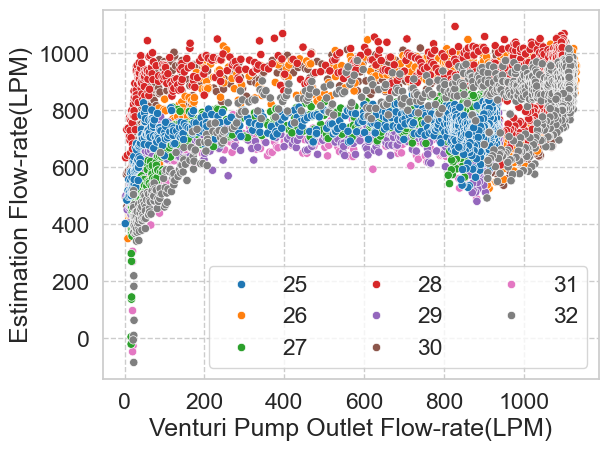

In [59]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Estimation Flow-rate(LPM)')
#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(data=linear_result, x='venturi_pump_outlet_F(LPM)', y='estimation_flow(LPM)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='lower right', ncols=3)

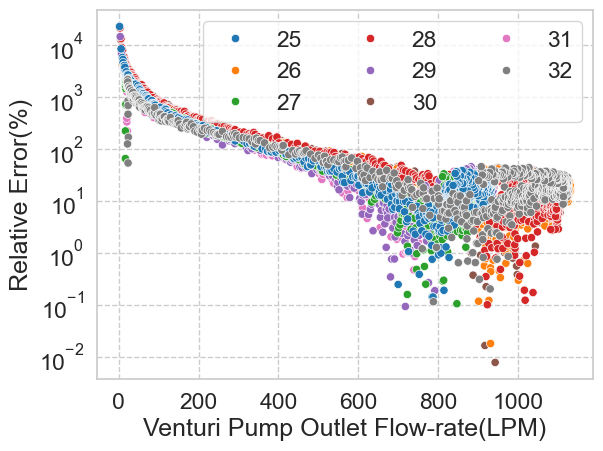

In [60]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
sns.scatterplot(data=linear_result, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='upper right', ncol=3)

In [61]:
# create LightGBM model
leaves = 32
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [62]:
basic_lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                    force_col_wise=True, verbose=1, n_jobs=-1)

In [63]:
basic_lgb_model.fit(X=train_feature, y=train_target, eval_set=(val_feature, val_target), eval_metric='L2', 
                    callbacks=[lgb.early_stopping(stopping_rounds=3000, min_delta=0.01), lgb.log_evaluation(period=100)])

[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 3
[LightGBM] [Info] Start training from score 792.531409
Training until validation scores don't improve for 3000 rounds
[100]	valid_0's l2: 102482
[200]	valid_0's l2: 95933
[300]	valid_0's l2: 90282.5
[400]	valid_0's l2: 85608.5
[500]	valid_0's l2: 81683
[600]	valid_0's l2: 78458.7
[700]	valid_0's l2: 75695.8
[800]	valid_0's l2: 73299.7
[900]	valid_0's l2: 71279
[1000]	valid_0's l2: 69500.4
[1100]	valid_0's l2: 67913.8
[1200]	valid_0's l2: 66506.9
[1300]	valid_0's l2: 65331.7
[1400]	valid_0's l2: 64252.6
[1500]	valid_0's l2: 63321
[1600]	valid_0's l2: 62492.7
[1700]	valid_0's l2: 61768.9
[1800]	valid_0's l2: 61130.6
[1900]	valid_0's l2: 60556.2
[2000]	valid_0's l2: 60022.5
[2100]	valid_0's l2: 59568.5
[2200]	valid_0's l2: 59136.2
[2300]	valid_0's l2: 58727.1
[2400]	valid_0's l2: 58423.4
[2500]	valid_0's l2: 58134.3
[2600]	valid_0's l2: 57936.7
[2700]	valid_0's l2: 

LGBMRegressor(force_col_wise=True, learning_rate=0.001, n_estimators=5000,
              n_jobs=-1, num_leaves=32, verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

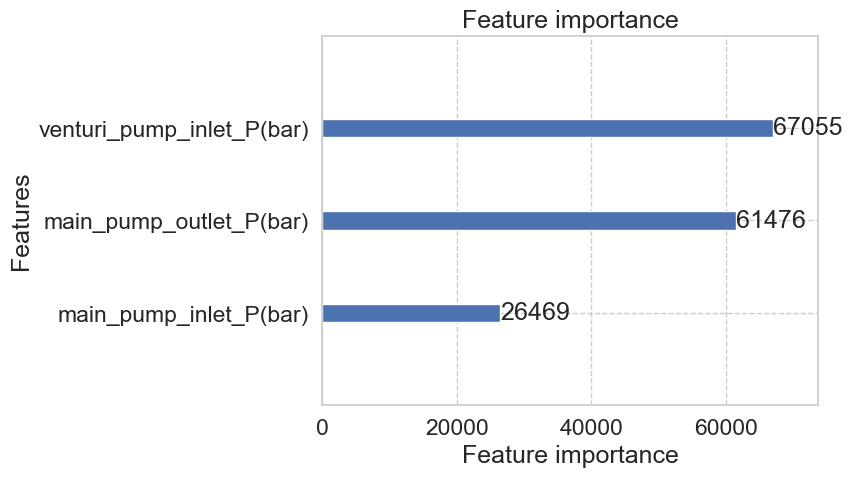

In [64]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
lgb.plot_importance(basic_lgb_model, max_num_features=5)

In [65]:
pred_output = basic_lgb_model.predict(val_feature, num_iteration=basic_lgb_model._best_iteration)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

basic_lgb_result = pd.DataFrame()
basic_lgb_result = pd.DataFrame(['basic_lgb']*len(pred_output), columns=['model_type'])
basic_lgb_result = pd.concat([basic_lgb_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
basic_lgb_result = pd.concat([basic_lgb_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
basic_lgb_result = pd.concat([basic_lgb_result, val_target], axis=1)
basic_lgb_result = pd.concat([basic_lgb_result, named_val_dataset['run_name']], axis=1)
basic_lgb_result.reset_index(inplace=True)

model_result = pd.concat([model_result, basic_lgb_result], axis=0)

In [66]:
model_result

index model_type  relative_error(%)  estimation_flow(LPM)  \
0         0     linear         223.224656            -26.065711   
1         1     linear         333.100831            -46.687765   
2         2     linear         390.765939             97.637884   
3         3     linear        1410.983658            305.490676   
4         4     linear        1260.180286            269.383706   
...     ...        ...                ...                   ...   
9300   9300  basic_lgb          13.513488            787.225314   
9301   9301  basic_lgb          13.866162            783.902334   
9302   9302  basic_lgb           5.675055            859.115369   
9303   9303  basic_lgb          13.977596            781.242571   
9304   9304  basic_lgb           2.571205            878.323512   

      absolute_error(LPM)  venturi_pump_outlet_F(LPM)  run_name  
0               47.218711                      21.153        31  
1               66.716765                      20.029        31  
2              -77.742884                      19.895        31  
3             -285.272676                      20.218        31  
4             -249.578706                      19.805        31  
...                   ...                         ...       ...  
9300                  NaN                     910.229        32  
9301                  NaN                     910.098        32  
9302                  NaN                     910.804        32  
9303                  NaN                     908.185        32  
9304                  NaN                     901.503        32  

[18610 rows x 7 columns]

In [67]:
print('The mae of prediction is:', f'{mean_absolute_error(val_target.to_numpy(), pred_output):.1f}')
print('r2 score is :', f'{r2_score(val_target.to_numpy(), pred_output):.3f}', end='\n\n')
print(np.mean(relative_error))

The mae of prediction is: 176.8
r2 score is : 0.494

106.126111882353


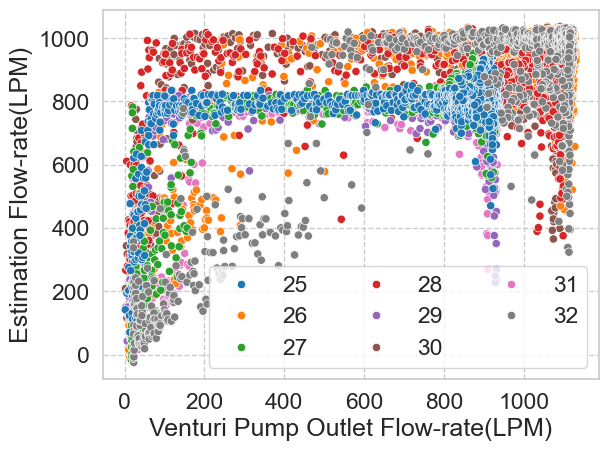

In [68]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Estimation Flow-rate(LPM)')
#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(data=basic_lgb_result, x='venturi_pump_outlet_F(LPM)', y='estimation_flow(LPM)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='lower right', ncol=3)

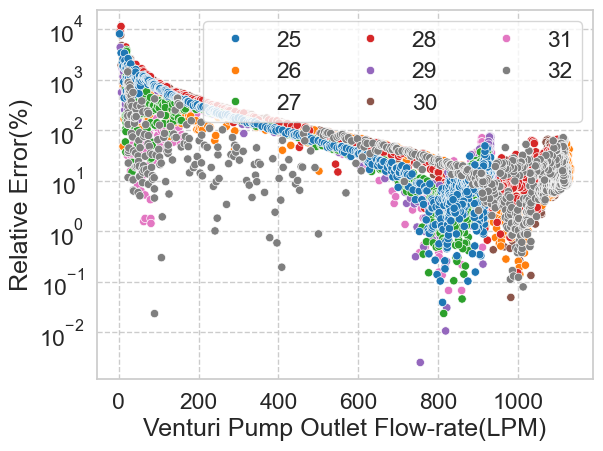

In [69]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
sns.scatterplot(data=basic_lgb_result, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='upper right', ncol=3)

In [70]:
poly = PolynomialFeatures(degree=3, include_bias=False)
train_poly_feature = pd.DataFrame(poly.fit_transform(train_feature), columns=poly.get_feature_names_out())
val_poly_feature = pd.DataFrame(poly.fit_transform(val_feature), columns=poly.get_feature_names_out())

In [71]:
print(poly.get_feature_names_out())

['main_pump_inlet_P(bar)' 'main_pump_outlet_P(bar)'
 'venturi_pump_inlet_P(bar)' 'main_pump_inlet_P(bar)^2'
 'main_pump_inlet_P(bar) main_pump_outlet_P(bar)'
 'main_pump_inlet_P(bar) venturi_pump_inlet_P(bar)'
 'main_pump_outlet_P(bar)^2'
 'main_pump_outlet_P(bar) venturi_pump_inlet_P(bar)'
 'venturi_pump_inlet_P(bar)^2' 'main_pump_inlet_P(bar)^3'
 'main_pump_inlet_P(bar)^2 main_pump_outlet_P(bar)'
 'main_pump_inlet_P(bar)^2 venturi_pump_inlet_P(bar)'
 'main_pump_inlet_P(bar) main_pump_outlet_P(bar)^2'
 'main_pump_inlet_P(bar) main_pump_outlet_P(bar) venturi_pump_inlet_P(bar)'
 'main_pump_inlet_P(bar) venturi_pump_inlet_P(bar)^2'
 'main_pump_outlet_P(bar)^3'
 'main_pump_outlet_P(bar)^2 venturi_pump_inlet_P(bar)'
 'main_pump_outlet_P(bar) venturi_pump_inlet_P(bar)^2'
 'venturi_pump_inlet_P(bar)^3']


In [72]:
new_train_feature = pd.DataFrame()
new_train_feature['linear_model_result'] = linear_model.predict(train_feature)
new_train_feature['basic_lgb_model_result'] = basic_lgb_model.predict(train_feature)
new_train_feature = pd.concat([new_train_feature, train_poly_feature], axis=1)

new_val_feature = pd.DataFrame()
#new_val_feature.reset_index(inplace=True, drop=True)
new_val_feature['linear_model_result'] = linear_model.predict(val_feature)
new_val_feature['basic_lgb_model_result'] = basic_lgb_model.predict(val_feature)
new_val_feature = pd.concat([new_val_feature, val_poly_feature], axis=1)

In [73]:
new_train_feature.describe()

linear_model_result  basic_lgb_model_result  main_pump_inlet_P(bar)  \
count         26629.000000            26629.000000            26629.000000   
mean            792.531409              792.531409               -1.873599   
std             171.712432              221.155929                0.096012   
min            -815.329216              -24.469327               -2.226000   
25%             693.698431              766.842801               -1.939000   
50%             795.720936              811.992901               -1.875000   
75%             919.614635              955.224071               -1.808000   
max            1189.472598             1037.013117               -1.476000   

       main_pump_outlet_P(bar)  venturi_pump_inlet_P(bar)  \
count             26629.000000               26629.000000   
mean                  0.272163                   1.558028   
std                   0.095743                   0.445622   
min                   0.001000                   0.001000   
25%                   0.224000                   1.357000   
50%                   0.245000                   1.382000   
75%                   0.368000                   2.016000   
max                   0.404000                   2.075000   

       main_pump_inlet_P(bar)^2  \
count              26629.000000   
mean                   3.519590   
std                    0.359497   
min                    2.178576   
25%                    3.268864   
50%                    3.515625   
75%                    3.759721   
max                    4.955076   

       main_pump_inlet_P(bar) main_pump_outlet_P(bar)  \
count                                    26629.000000   
mean                                        -0.511096   
std                                          0.184514   
min                                         -0.839670   
25%                                         -0.683757   
50%                                         -0.466200   
75%                                         -0.408726   
max                                         -0.001611   

       main_pump_inlet_P(bar) venturi_pump_inlet_P(bar)  \
count                                      26629.000000   
mean                                          -2.924065   
std                                            0.865964   
min                                           -4.409017   
25%                                           -3.760755   
50%                                           -2.675977   
75%                                           -2.449744   
max                                           -0.001754   

       main_pump_outlet_P(bar)^2  \
count               26629.000000   
mean                    0.083239   
std                     0.048027   
min                     0.000001   
25%                     0.050176   
50%                     0.060025   
75%                     0.135424   
max                     0.163216   

       main_pump_outlet_P(bar) venturi_pump_inlet_P(bar)  ...  \
count                                       26629.000000  ...   
mean                                            0.465765  ...   
std                                             0.249992  ...   
min                                             0.000070  ...   
25%                                             0.306290  ...   
50%                                             0.335097  ...   
75%                                             0.742775  ...   
max                                             0.815272  ...   

       main_pump_inlet_P(bar)^3  \
count              26629.000000   
mean                  -6.628792   
std                    1.013324   
min                  -11.029999   
25%                   -7.290099   
50%                   -6.591797   
75%                   -5.910106   
max                   -3.215578   

       main_pump_inlet_P(bar)^2 main_pump_outlet_P(bar)  \
count                                      26629.000000   
mean                                           

In [74]:
# create LightGBM model
leaves = 7
lr = 0.001
n_estimators = 5000
boosting_type = 'gbdt'
max_bin = 30

In [75]:
new_lgb_model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=lr, boosting_type=boosting_type, max_depth=-1, num_leaves=leaves,
                                  force_col_wise=True, verbose=1, n_jobs=-1, min_split_gain=1000, min_child_samples=500, reg_alpha=0.9, reg_lambda=0.9)

In [76]:
new_lgb_model.fit(X=new_train_feature, y=train_target, eval_set=(new_val_feature, val_target), eval_metric='L2', 
                  callbacks=[lgb.early_stopping(stopping_rounds=5000, min_delta=0.001), lgb.log_evaluation(period=100)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 5268
[LightGBM] [Info] Number of data points in the train set: 26629, number of used features: 21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 792.531409
Training until validation scores don't improve for 5000 rounds
[100]	valid_0's l2: 100600
[200]	valid_0's l2: 92615.5
[300]	valid_0's l2: 86015.9
[400]	valid_0's l2: 80559
[500]	valid_0's l2: 76050.9
[600]	valid_0's l2: 72335.6
[700]	valid_0's l2: 69247.8
[800]	valid_0's l2: 66684.8
[900]	valid_0's l2: 64564.8
[1000]	valid_0's l2: 62804.5
[1100]	valid_0's l2: 61342.9
[1200]	valid_0's l2: 60127.1
[1300]	valid_0's l2: 59117.2
[1400]	valid_0's l2: 58276.8
[1500]	valid_0's l2: 57579.2
[1600]	valid_0's l2: 57002.4
[1700]	valid_0's l2: 56517.6
[1800]	valid_0's l2: 56107.5
[1900]	valid_0's l2: 55758.2
[2000]	valid_0's l2: 55470.4
[2100]	valid_0's l2: 55231.

LGBMRegressor(force_col_wise=True, learning_rate=0.001, min_child_samples=500,
              min_split_gain=1000, n_estimators=5000, n_jobs=-1, num_leaves=7,
              reg_alpha=0.9, reg_lambda=0.9, verbose=1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

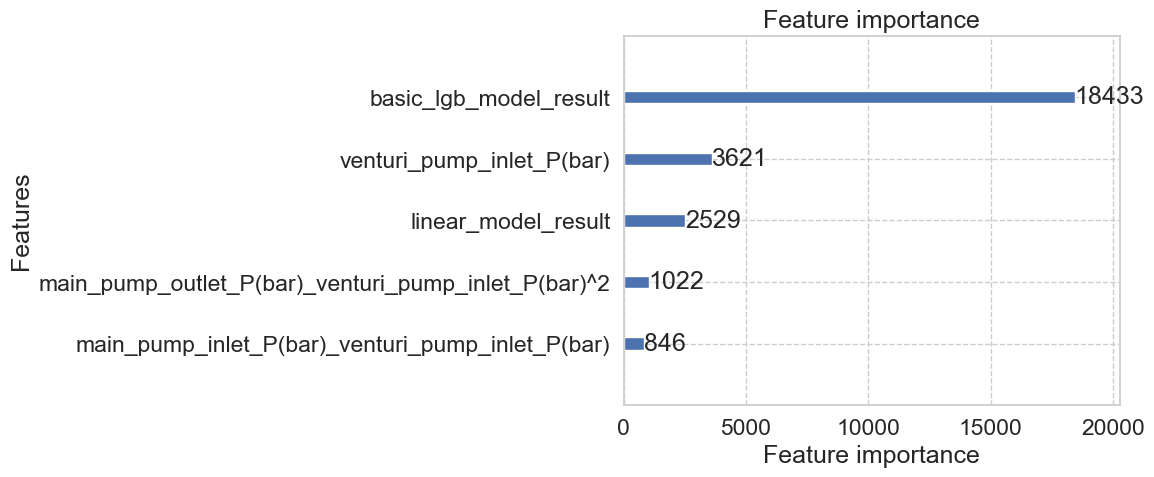

In [77]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
lgb.plot_importance(new_lgb_model, max_num_features=5)

In [78]:
model_result

index model_type  relative_error(%)  estimation_flow(LPM)  \
0         0     linear         223.224656            -26.065711   
1         1     linear         333.100831            -46.687765   
2         2     linear         390.765939             97.637884   
3         3     linear        1410.983658            305.490676   
4         4     linear        1260.180286            269.383706   
...     ...        ...                ...                   ...   
9300   9300  basic_lgb          13.513488            787.225314   
9301   9301  basic_lgb          13.866162            783.902334   
9302   9302  basic_lgb           5.675055            859.115369   
9303   9303  basic_lgb          13.977596            781.242571   
9304   9304  basic_lgb           2.571205            878.323512   

      absolute_error(LPM)  venturi_pump_outlet_F(LPM)  run_name  
0               47.218711                      21.153        31  
1               66.716765                      20.029        31  
2              -77.742884                      19.895        31  
3             -285.272676                      20.218        31  
4             -249.578706                      19.805        31  
...                   ...                         ...       ...  
9300                  NaN                     910.229        32  
9301                  NaN                     910.098        32  
9302                  NaN                     910.804        32  
9303                  NaN                     908.185        32  
9304                  NaN                     901.503        32  

[18610 rows x 7 columns]

In [79]:
pred_output = new_lgb_model.predict(new_val_feature, num_iteration=basic_lgb_model._best_iteration)
relative_error = abs(val_target.to_numpy()-pred_output)/abs(val_target.to_numpy())*100

new_lgb_result = pd.DataFrame()
new_lgb_result = pd.DataFrame(['new_lgb']*len(pred_output), columns=['model_type'])
new_lgb_result = pd.concat([new_lgb_result, pd.DataFrame(pred_output, columns=['estimation_flow(LPM)'])], axis=1)
new_lgb_result = pd.concat([new_lgb_result, pd.DataFrame(relative_error, columns=['relative_error(%)'])], axis=1)
new_lgb_result = pd.concat([new_lgb_result, val_target], axis=1)
new_lgb_result = pd.concat([new_lgb_result, named_val_dataset['run_name']], axis=1)
new_lgb_result.reset_index(inplace=True)

model_result = pd.concat([model_result, new_lgb_result], axis=0)

In [80]:
model_result

index model_type  relative_error(%)  estimation_flow(LPM)  \
0         0     linear         223.224656            -26.065711   
1         1     linear         333.100831            -46.687765   
2         2     linear         390.765939             97.637884   
3         3     linear        1410.983658            305.490676   
4         4     linear        1260.180286            269.383706   
...     ...        ...                ...                   ...   
9300   9300    new_lgb          11.443494            806.066998   
9301   9301    new_lgb          11.430747            806.066998   
9302   9302    new_lgb           0.772636            903.766803   
9303   9303    new_lgb          10.811298            809.998413   
9304   9304    new_lgb           0.282879            898.952836   

      absolute_error(LPM)  venturi_pump_outlet_F(LPM)  run_name  
0               47.218711                      21.153        31  
1               66.716765                      20.029        31  
2              -77.742884                      19.895        31  
3             -285.272676                      20.218        31  
4             -249.578706                      19.805        31  
...                   ...                         ...       ...  
9300                  NaN                     910.229        32  
9301                  NaN                     910.098        32  
9302                  NaN                     910.804        32  
9303                  NaN                     908.185        32  
9304                  NaN                     901.503        32  

[27915 rows x 7 columns]

In [81]:
print('The mae of prediction is:', f'{mean_absolute_error(val_target.to_numpy(), pred_output):.1f}')
print('r2 score is :', f'{r2_score(val_target.to_numpy(), pred_output):.3f}', end='\n\n')
print(np.mean(relative_error))

The mae of prediction is: 167.9
r2 score is : 0.511

83.92906675379021


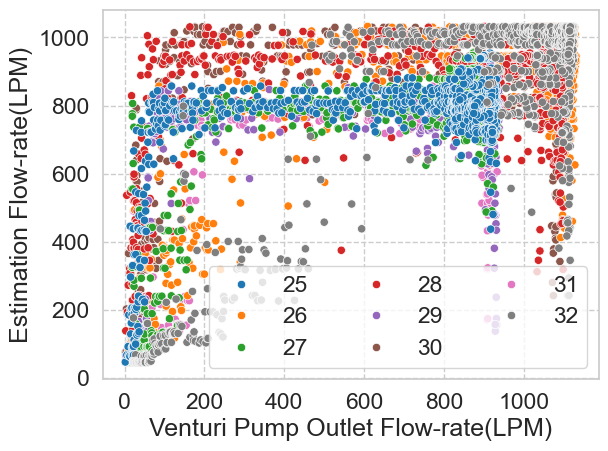

In [82]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Estimation Flow-rate(LPM)')
#sns.kdeplot(x=named_val_target, y=pred_output, color='silver')
sns.scatterplot(data=new_lgb_result, x='venturi_pump_outlet_F(LPM)', y='estimation_flow(LPM)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='lower right', ncol=3)

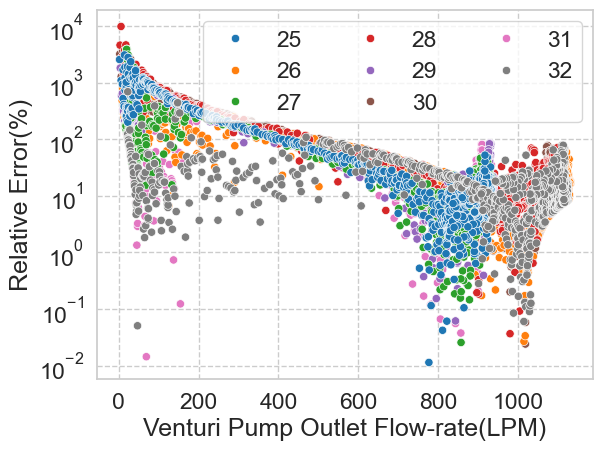

In [83]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
#sns.kdeplot(x=named_val_target, y=relative_error, color='silver')
sns.scatterplot(data=new_lgb_result, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='run_name', palette='tab10', legend='full')
plt.legend(loc='upper right', ncol=3)

<Axes: xlabel='Sample(n)', ylabel='Relative Error(%)'>

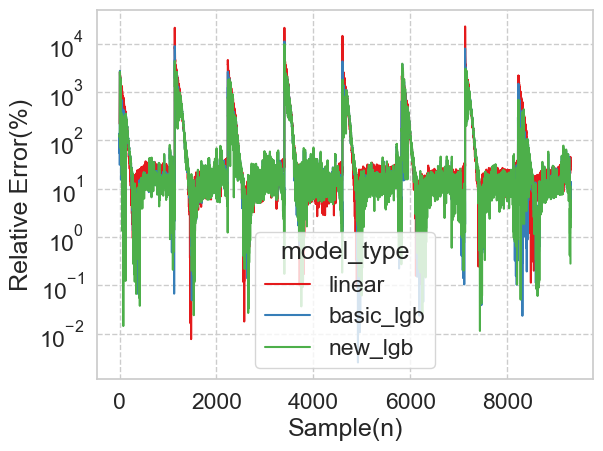

In [84]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.ylabel('Relative Error(%)')
plt.yscale('log')
plt.xlabel('Sample(n)')

sns.lineplot(data=model_result, x='index', y='relative_error(%)', hue='model_type', palette='Set1')

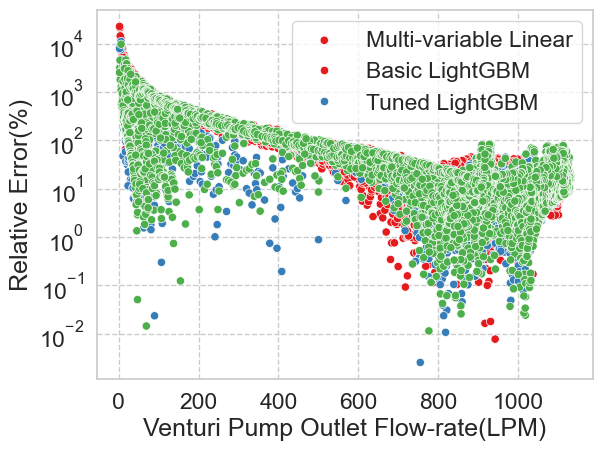

In [85]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
sns.scatterplot(data=model_result, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='model_type', palette='Set1')
plt.legend(['Multi-variable Linear', 'Basic LightGBM', 'Tuned LightGBM'], loc='upper right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


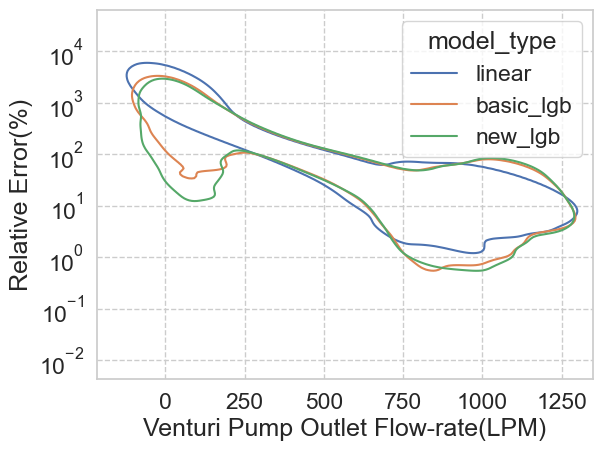

In [86]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Venturi Pump Outlet Flow-rate(LPM)')
plt.ylabel('Relative Error(%)')
plt.legend(loc='lower left', ncol=3)
ked_plot = sns.kdeplot(data=model_result, x='venturi_pump_outlet_F(LPM)', y='relative_error(%)', hue='model_type', levels=2)

In [87]:
print(np.abs(val_target.to_numpy()-new_lgb_model.predict(new_val_feature)))

[24.01507422 26.26176055 25.27307422 ...  7.03719696 98.18658671
  2.55016378]


In [88]:
new_lgb_predout = new_lgb_model.predict(new_val_feature)
new_lgb_predout_df = pd.DataFrame(new_lgb_predout, columns=['Estimation_Flow(LPM)'])
new_lgb_rl_error = (np.abs(val_target.to_numpy()-new_lgb_predout)/np.abs(val_target.to_numpy()))*100
new_lgb_rl_error_df = pd.DataFrame(new_lgb_rl_error, columns=['Relative_Error(%)'])
new_lgb_abs_error = np.abs(val_target.to_numpy()-new_lgb_predout)
new_lgb_abs_error_df = pd.DataFrame(new_lgb_abs_error, columns=['Absolute_Error(LPM)'])

print(new_lgb_rl_error_df.mean())
print(new_lgb_abs_error_df.mean())

Relative_Error(%)    83.929067
dtype: float64
Absolute_Error(LPM)    167.862092
dtype: float64


In [89]:
flow_result = pd.concat([named_val_dataset, new_lgb_predout_df, new_lgb_abs_error_df, new_lgb_rl_error_df], axis=1)
flow_result.shape

(9305, 13)

In [90]:
flow_transient = flow_result[flow_result['venturi_pump_outlet_F(LPM)']<750]
flow_transient.reset_index(inplace=True, drop=True)
flow_transient = pd.concat([flow_transient, pd.DataFrame(['transient']*flow_transient.shape[0], columns=['phase_type'])], axis=1)

flow_steady = flow_result[flow_result['venturi_pump_outlet_F(LPM)']>750]
flow_steady.reset_index(inplace=True, drop=True)

flow_steady = pd.concat([flow_steady, pd.DataFrame(['steady']*flow_steady.shape[0], columns=['phase_type'])], axis=1)

flow_phase = pd.concat([flow_transient, flow_steady], axis=0)
flow_phase.reset_index(inplace=True, drop=True)

In [91]:
flow_phase

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
0        12.697                  -1.730                    0.037   
1        12.746                  -2.013                    0.037   
2        12.796                  -1.887                    0.038   
3        12.846                  -1.787                    0.038   
4        12.896                  -1.921                    0.036   
...         ...                     ...                      ...   
9300     67.641                  -1.829                    0.012   
9301     67.691                  -1.893                    0.010   
9302     67.740                  -1.728                    0.005   
9303     67.791                  -2.049                    0.005   
9304     67.840                  -1.629                    0.001   

      venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
0                         0.026                   -2.686   
1                         0.099                   -4.661   
2                         0.181                   -3.734   
3                         0.320                   -4.742   
4                         0.326                   -3.033   
...                         ...                      ...   
9300                      0.470                  180.603   
9301                      0.467                  179.677   
9302                      0.449                  179.361   
9303                      0.443                  179.573   
9304                      0.450                  178.389   

      venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
0                         21.153               750              45   
1                         20.029               750              45   
2                         19.895               750              45   
3                         20.218               750              45   
4                         19.805               750              45   
...                          ...               ...             ...   
9300                     910.229               900              45   
9301                     910.098               900              45   
9302                     910.804               900              45   
9303                     908.185               900              45   
9304                     901.503               900              45   

      suction_height_of_venturi(m)  run_name  Estimation_Flow(LPM)  \
0                            -0.45        31             45.168074   
1                            -0.45        31             46.290761   
2                            -0.45        31             45.168074   
3                            -0.45        31             45.168074   
4                            -0.45        31             45.161081   
...                            ...       ...                   ...   
9300                         -0.45        32            806.066998   
9301                         -0.45        32            806.066998   
9302                         -0.45        32            903.766803   
9303                         -0.45        32            809.998413   
9304                         -0.45        32            898.952836   

      Absolute_Error(LPM)  Relative_Error(%) phase_type  
0               24.015074         113.530347  transient  
1               26.261761         131.118681  transient  
2               25.273074         127.032291  transient  
3               24.950074         123.405254  transient  
4               25.356081         128.028687  transient  
...                   ...                ...        ...  
9300           104.162002          11.443494     steady  
9301           104.031002          11.430747     steady  
9302             7.037197           0.772636     steady  
9303            98.186587          10.811298     steady  
9304             2.550164           0.282879     steady  

[9305 rows x 14 columns]

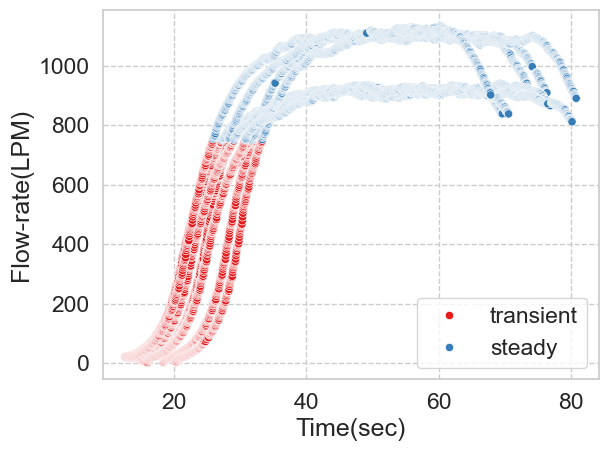

In [92]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Time(sec)')
plt.ylabel('Flow-rate(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='venturi_pump_outlet_F(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='lower right')

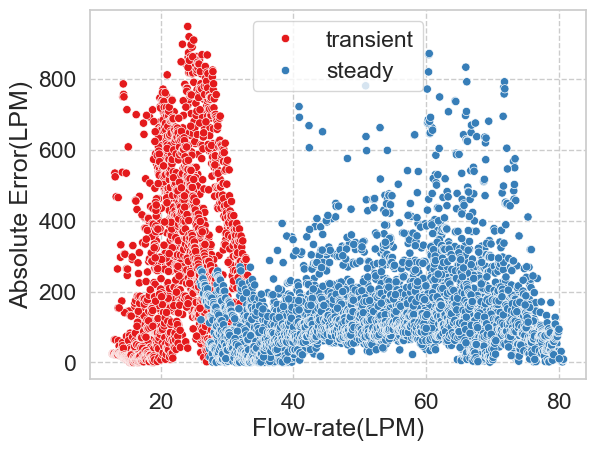

In [93]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

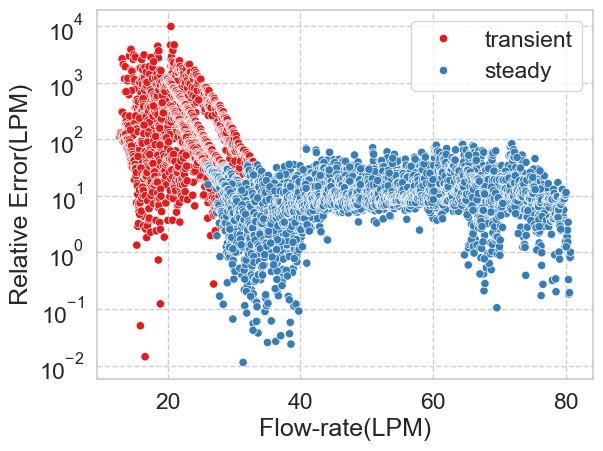

In [94]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='time(sec)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

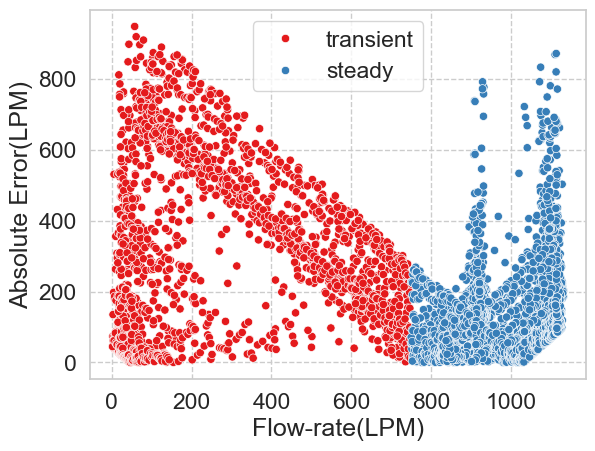

In [95]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Absolute Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')
plt.legend(loc='upper center')

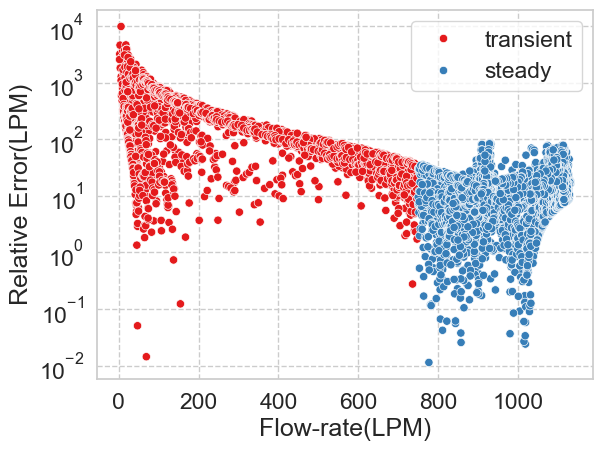

In [96]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.yscale('log')
plt.xlabel('Flow-rate(LPM)')
plt.ylabel('Relative Error(LPM)')
sns.scatterplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)',y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.legend(loc='upper right')

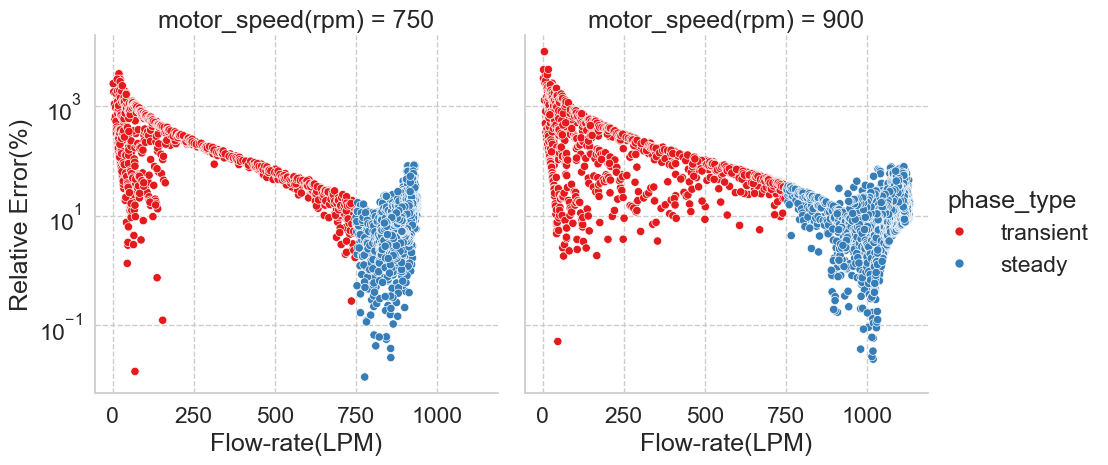

In [97]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='motor_speed(rpm)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

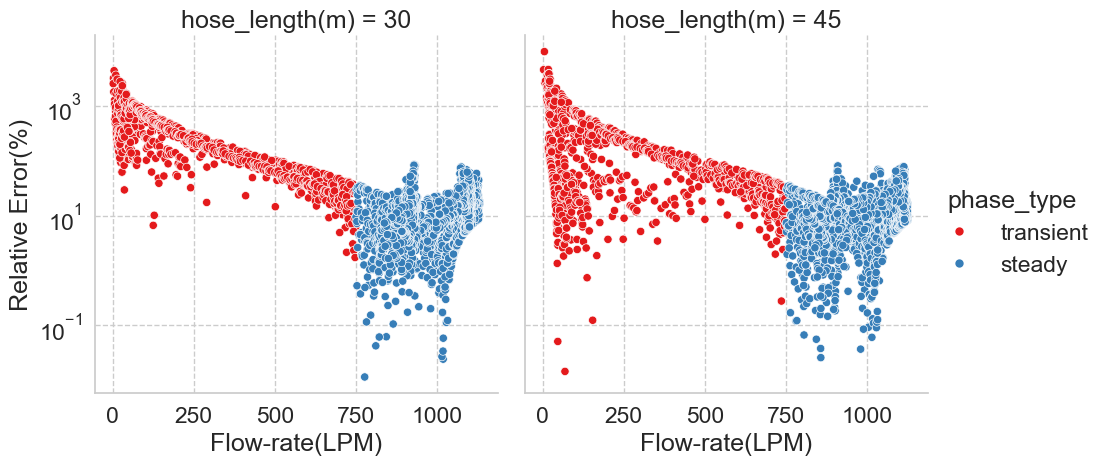

In [98]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='hose_length(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

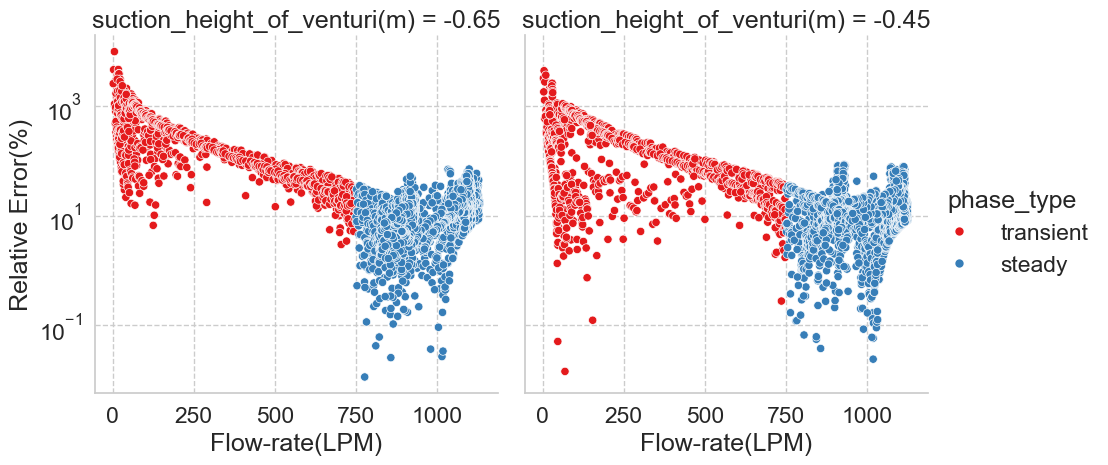

In [99]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
re = sns.relplot(data=flow_phase, x='venturi_pump_outlet_F(LPM)', y='Relative_Error(%)', hue='phase_type', palette='Set1', col='suction_height_of_venturi(m)')
plt.yscale('log')
re.set_ylabels('Relative Error(%)')
re.set_xlabels('Flow-rate(LPM)')

In [100]:
flow_phase.describe()

time(sec)  main_pump_inlet_P(bar)  main_pump_outlet_P(bar)  \
count  9305.000000             9305.000000              9305.000000   
mean     45.045720               -1.851021                 0.270931   
std      17.353969                0.096207                 0.095845   
min      12.697000               -2.195000                 0.001000   
25%      30.244000               -1.919000                 0.230000   
50%      44.845000               -1.852000                 0.240000   
75%      59.691000               -1.785000                 0.370000   
max      80.745000               -1.519000                 0.398000   

       venturi_pump_inlet_P(bar)  main_pump_outlet_F(LPM)  \
count                9305.000000              9305.000000   
mean                    1.545206               157.181888   
std                     0.430442                73.795535   
min                     0.011000                -4.790000   
25%                     1.358000               103.236000   
50%                     1.378000               159.407000   
75%                     2.013000               236.329000   
max                     2.052000               246.386000   

       venturi_pump_outlet_F(LPM)  motor_speed(rpm)  hose_length(m)  \
count                 9305.000000       9305.000000     9305.000000   
mean                   805.678338        823.250940       37.629769   
std                    331.844553         74.983632        7.499280   
min                      1.748000        750.000000       30.000000   
25%                    772.010000        750.000000       30.000000   
50%                    911.693000        750.000000       45.000000   
75%                   1062.772000        900.000000       45.000000   
max                   1131.759000        900.000000       45.000000   

       suction_height_of_venturi(m)     run_name  Estimation_Flow(LPM)  \
count                   9305.000000  9305.000000           9305.000000   
mean                      -0.552504    28.455562            793.956199   
std                        0.099974     2.249053            225.964294   
min                       -0.650000    25.000000             45.161081   
25%                       -0.650000    27.000000            773.099811   
50%                       -0.650000    28.000000            813.430396   
75%                       -0.450000    30.000000            940.747431   
max                       -0.450000    32.000000           1032.447252   

       Absolute_Error(LPM)  Relative_Error(%)  
count          9305.000000        9305.000000  
mean            167.862092          83.929067  
std             160.350315         289.177182  
min               0.009931           0.011427  
25%              73.733271           8.584129  
50%             118.076774          13.544265  
75%             185.365739          25.436897  
max             947.957875        9824.420182

<Axes: xlabel='time(sec)', ylabel='Absolute_Error(LPM)'>

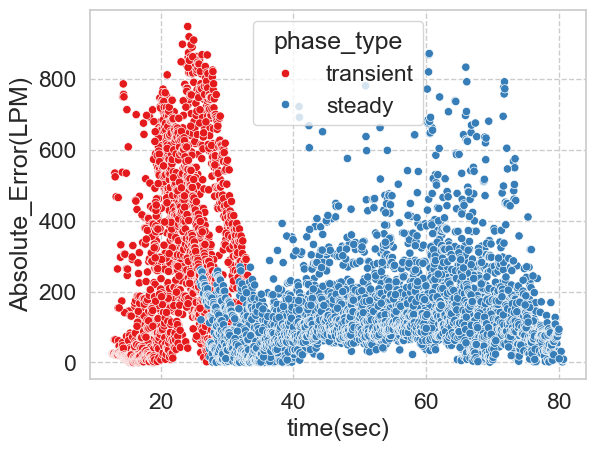

In [101]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Absolute_Error(LPM)', hue='phase_type', palette='Set1')

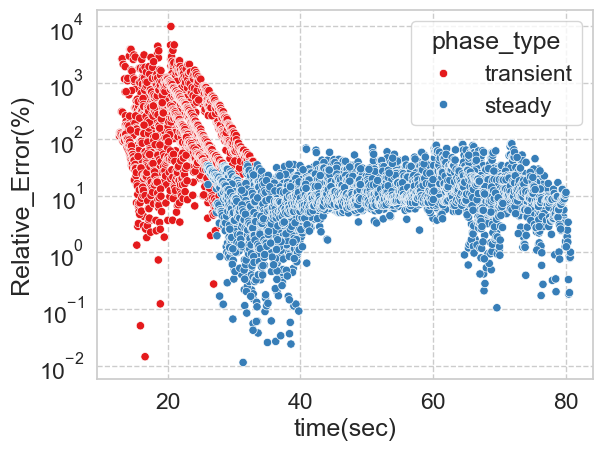

In [102]:
sns.scatterplot(data=flow_phase, x='time(sec)', y='Relative_Error(%)', hue='phase_type', palette='Set1')
plt.yscale('log')

In [103]:
a = flow_phase.copy()
a = a[a['suction_height_of_venturi(m)'] == -0.45]
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

161.82946045146994
67.3501187764551
(4536, 14)


In [104]:
a = flow_phase.copy()
a = a[a['phase_type'] == 'transient']
print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

a = flow_phase.copy()
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())
print(a.shape)
print('')

301.4292741572676
307.14641275165536
(2251, 14)

125.23950458963677
12.69824086192822
(7054, 14)


In [105]:
test_vars = ['motor_speed(rpm)', 'hose_length(m)', 'suction_height_of_venturi(m)']
test_var_vals = [700, 900, 30, 50, -0.65, -0.45]

a = flow_phase.copy()
a = a[a['motor_speed(rpm)'] == 750]
a = a[a['phase_type'] == 'steady']

print(a['Absolute_Error(LPM)'].mean())
print(a['Relative_Error(%)'].mean())

107.28728417974591
11.861380096374589


In [107]:
# save model
joblib.dump(linear_model, 'saved_model'+os.sep+'linear_model'+'.pkl')
print('linear model is saved!')

joblib.dump(basic_lgb_model, 'saved_model' + os.sep + 'basic_lgb_model' + '.pkl')
print('lgb model is saved!')

joblib.dump(new_lgb_model, 'saved_model' + os.sep + 'new_model' + '.pkl')
print('new lgb model is saved!')


linear model is saved!
lgb model is saved!
new lgb model is saved!


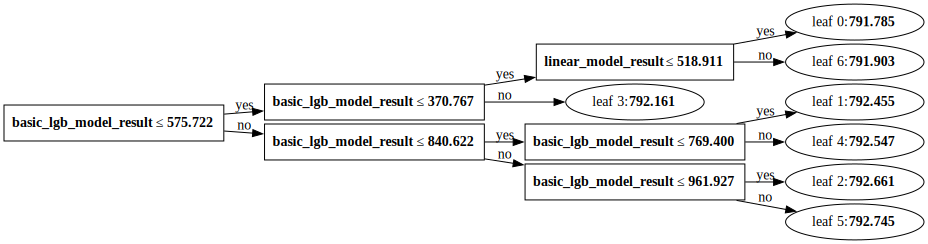

In [108]:
lgb.create_tree_digraph(new_lgb_model)